## AI Blitz #7 Mars Rotation 0.0 MSE simple Solution pipeline with EfficientNet B4

### **Hello!**
In this notebook I present my journey of finding the (maybe?) perfect solution for this task.
In the first part I will tell you my solution.

In the second part I will show you the code and explain it.

**Problem**

In this task you get an image of the mars which has different positions and you have to output the rotation in the Z - axis for the mars.
 
### My solution

In the development of this solution i tried to be as simple and effective as possible. For this reason I didn't use any fancy augmentatios or some complicated training methods. That is why the code is very short and easy to understand for beginners.

For the code I mostly use Pytorch Lightning to speed up the coding and to simplify the code a lot.

**Key parts:**
*   strong model -> *EfficientNets B4 360 classes*
*   *230* crop size
*   *TTA 4* (Test time augmentations)

*From REGRESSION task to CLASSIFICATION task!*

This was very important because a classification task is always easier than a regression task. That is why the model has 360 output classes.

**Preprocessing**

I used 230 x 230 cropped images because its the size where the mars is always nearly fully visible and there is no gap between the mars and the image border.
I only used flipping at training.

**Model**

I chose EfficientNet B4 with pretrained weights because it is a lightweight and strong model. This means that you don't have to use complicated training methods or heavy augmentations. It is also very fast at training.

**Training**


*   50 epochs
*   3e-4 lr without lr schedules
*   Adam optimiser
*   64 batch size
*   mixes precision -> more speed and efficiency
*   Cross Entropy as loss fn
*   f1 score metric

**Inference**

For inference I chose the best model from training and used TTA.
TTA stands for TestTimeAugmetation and it uses augmentations to let the model predict different outputs. In my case i used vertical flip and horizontal flip so that i can make 4 different images out of one. After that the mean ouput of the 4 runs will be taken for the submission.





---





### Install the packages

In [ ]:
!pip install -q aicrowd-cli==0.1
!pip install -q efficientnet_pytorch
!pip install -q pytorch-lightning

     |████████████████████████████████| 61kB 5.5MB/s 
     |████████████████████████████████| 204kB 14.5MB/s 
     |████████████████████████████████| 163kB 24.3MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
     |████████████████████████████████| 71kB 8.6MB/s 
     |████████████████████████████████| 829kB 5.6MB/s 
     |████████████████████████████████| 112kB 13.8MB/s 
     |████████████████████████████████| 276kB 11.6MB/s 
     |████████████████████████████████| 829kB 13.1MB/s 
     |████████████████████████████████| 184kB 20.2MB/s 
     |████████████████████████████████| 1.3MB 20.9MB/s 
     |████████████████████████████████| 143kB 39.4MB/s 
     |████████████████████████████████| 296kB 31.2MB/s 


### Login to aicrowd's API

In [ ]:
API_KEY = ""  # Please enter your API Key from [https://www.aicrowd.com/participants/me]
!aicrowd login --api-key $API_KEY

API Key valid
Saved API Key successfully!


### Download the dataset

In [ ]:
!aicrowd dataset download --challenge mars-rotation

!rm -rf data
!mkdir data

!unzip -q train.zip  -d data/train
!unzip -q val.zip -d data/val
!unzip -q test.zip  -d data/test

!mv train.csv data/train.csv
!mv val.csv data/val.csv
!mv sample_submission.csv data/sample_submission.csv

sample_submission.csv: 100% 95.9k/95.9k [00:00<00:00, 588kB/s]
test.zip: 100% 76.5M/76.5M [00:02<00:00, 30.7MB/s]
train.csv: 100% 377k/377k [00:00<00:00, 1.20MB/s]
train.zip: 100% 306M/306M [00:08<00:00, 34.7MB/s]
val.csv: 100% 33.7k/33.7k [00:00<00:00, 477kB/s]
val.zip: 100% 30.6M/30.6M [00:02<00:00, 11.1MB/s]


### Import libraries

In [ ]:
import os
import cv2
import pandas as pd

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from efficientnet_pytorch import EfficientNet
import pytorch_lightning as pl
from pytorch_lightning import Trainer

import matplotlib.pyplot as plt
import albumentations as A
from albumentations.augmentations.transforms import Flip


### Define the dataset

A Dataset consists of a __getitem__ functions with a index parameter and a __len__ functions wich returns the lenght of the dataset. If you want to use a DataLoader it is essential to set up a Dataset like this.

In [ ]:
class ImgDataset(Dataset):
    def __init__(self,df,mode,transforms = None):
        self.imageID = df['ImageID']      # Set up the paths and labels
        self.labels = df['label']
        self.transforms = transforms
        self.mode = mode
        
    def __getitem__(self,x):
        # Read images
        path = self.imageID.iloc[x]
        label = float(self.labels.iloc[x])
        i = cv2.imread(f'data/{self.mode}/'+str(path)+'.jpg')
        i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)

        # Apply transformations
        if self.transforms:
            i = self.transforms(image = i)['image']
        i = cv2.resize(i,(128,128))
        i = torch.tensor(i) / 255.0
        i = i.permute(2,0,1)

        if self.mode != 'test':
            return i, label-1
        else:
            return i
    
    def __len__(self):
        return len(self.imageID)

# Functions return dataset
def getTrainDs(train_tr = None):
    train_df = pd.read_csv('data/train.csv')
    return ImgDataset(train_df,'train',train_tr)

def getValDs(val_tr):
    val_df = pd.read_csv('data/val.csv')
    return ImgDataset(val_df,'val',val_tr)

def getTestDs(test_tr):
    val_df = pd.read_csv('data/sample_submission.csv')
    return ImgDataset(val_df,'test',test_tr)

def writeSub(p):
    test_df = pd.read_csv('data/sample_submission.csv')

### Find the optimal image size

Here is a small demonstatration for the reason of choosing 230 as crop size.


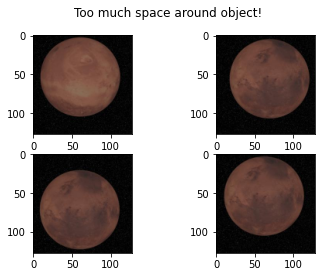

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
axes = [ax1,ax2,ax3,ax4]

train_tr = A.Compose([
    A.CenterCrop(230,230,always_apply=True),
])

noresizeLoader = getTrainDs()
resizeLoader = getTrainDs(train_tr)

fig.suptitle('Too much space around object!')
for i, ax in enumerate(axes):
  ax.imshow(noresizeLoader.__getitem__(i)[0].permute(1,2,0))

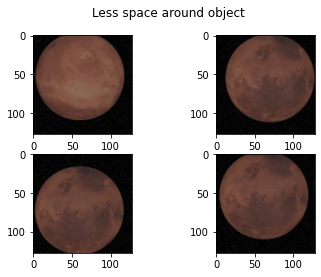

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
axes = [ax1,ax2,ax3,ax4]

fig.suptitle('Less space around object')
for i, ax in enumerate(axes):
  ax.imshow(resizeLoader.__getitem__(i)[0].permute(1,2,0))

### The lightning module

If you want to use the trainer from Pytorch Lightning you need a Lightning Module. It is like a normal model in PyTorch but it also consist of training/validation/test step functions and dataloader-setup functions. It also can log the metrics to tensorboard with self.log().

The step functions will get called from the trainer each iteration. It has to return the loss so that the model can be optimised.
The _dataloader functions have to return the loaders.

In [ ]:
class Classifier(pl.LightningModule):
    def __init__(self,args):
        super().__init__()
        self.args = args
        self.resnet = EfficientNet.from_pretrained('efficientnet-b4',num_classes = 360)

    def forward(self, x):
        x = self.resnet(x)
        return x
    def training_step(self, batch, batch_idx):
        x, y = batch
        p = self(x)
        loss = F.cross_entropy(p, y.long())

        self.log('train_loss', loss) # log to tensorboard
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        p = self(x)
        loss = F.cross_entropy(p, y.long())
        f1 = f1_loss(y,p.argmax(1))

        self.log('val_loss', loss)# log to tensorboard
        self.log('val_f1',f1)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        p = self(x)
        
        loss = F.cross_entropy(p, y.long())
        mse = F.mse_loss(p.argmax(1),y.float())

        self.log('test_loss', loss)# log to tensorboard
        self.log('test_mse',mse)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.args['lr'])
        return optimizer
    
    def train_dataloader(self):
        train_ds = getTrainDs(self.args['train_tr'])
        loader= DataLoader(train_ds,batch_size = self.args['batch_size'],num_workers = 4,shuffle=True)
        return loader
    
    def val_dataloader(self):
        val_ds = getValDs(self.args['val_tr'])
        loader= DataLoader(val_ds,batch_size = self.args['batch_size'],num_workers = 4)
        return loader
    
    def predict_dataloader(self):
        val_ds = getTestDs(self.args['val_tr'])
        loader= DataLoader(val_ds,batch_size = self.args['batch_size'],num_workers = 4)
        return loader

### F1 score metric

I used the f1_loss to compute the score on the validation set to get a rough estimate of the score on the leaderboard.

It is the harmonic mean of the precision and recall scores. 

In [ ]:
def f1_loss(y_true:torch.Tensor, y_pred:torch.Tensor, is_training=False) -> torch.Tensor:

    assert y_true.ndim == 1
    assert y_pred.ndim == 1 or y_pred.ndim == 2

    if y_pred.ndim == 2:
        y_pred = y_pred.argmax(dim=1)
    tp = (y_true * y_pred).sum().to(torch.float32)
    tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
    fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum().to(torch.float32)

    epsilon = 1e-7

    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)

    f1 = 2* (precision*recall) / (precision + recall + epsilon)
    f1.requires_grad = is_training
    return f1

## Training

For the training I used the Trainer from Pytorch Lightning.
On colab 50 epochs of training takes about 2 hours and 45 minutes.
On my personal computer with a RTX 2070 Super it only took 1 hour and 34 minutes.

In [ ]:
def run_training(): 
  img_size = 230

  ckpt = pl.callbacks.model_checkpoint.ModelCheckpoint(save_top_k = -1)
  
  trainer = Trainer(max_epochs = 50,  
                    gpus = 1, 
                    callbacks = ckpt, 
                    precision=16, 
                    amp_level='O1',
                    deterministic=True,
                    fast_dev_run = False
                    )

  train_tr = A.Compose([
      A.CenterCrop(img_size,img_size,always_apply=True),
      Flip()
  ])

  val_tr = A.Compose([
      A.CenterCrop(img_size,img_size,always_apply=True)
  ])

  model = Classifier({'lr':3e-4,'batch_size':64,'train_tr':train_tr,'val_tr':val_tr}) # Here are all hyperparameters
  trainer.fit(model)
  trainer.test(model)

In [ ]:
# Uncomment for training
#run_training()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Loaded pretrained weights for efficientnet-b4



  | Name   | Type         | Params
----------------------------------------
0 | resnet | EfficientNet | 18.2 M
----------------------------------------
18.2 M    Trainable params
0         Non-trainable params
18.2 M    Total params
72.776    Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Inference

For inference i am using TTA 4. I am using 4 different arrangemets of augmentations. One without one only with vertical flip one only with horizontal flip and one with both augmentations. Then the model will predict on those four sets and the mean output will be calculated.

In [ ]:
def run_inference():
  tr0 = A.Compose([
          A.CenterCrop(230,230,always_apply=True)
  ])

  tr1 = A.Compose([
      A.CenterCrop(230,230,always_apply=True),
      A.VerticalFlip(p = 1)
  ])

  tr2 = A.Compose([
      A.CenterCrop(230,230,always_apply=True),
      A.HorizontalFlip(p = 1)
  ])

  tr3 = A.Compose([
      A.CenterCrop(230,230,always_apply=True),
      A.HorizontalFlip(p = 1),
      A.VerticalFlip(p = 1)
  ])

  tr_list = [tr0,tr1,tr2,tr3]
  concat = torch.tensor([])

  for tr in tr_list:
      # INSERT VERSION NUMBER 
      path = 'lightning_logs/version_0/checkpoints/latest.ckpt' # Use path of latest model
      trainer = Trainer(gpus = 1, precision=16, amp_level='O1',deterministic=True)

      m = Classifier({'lr':3e-4,'batch_size':64,'train_tr':None,'val_tr':tr})

      ckpt = torch.load(path)
      m.load_state_dict(ckpt['state_dict'])
      
      out = trainer.predict(m)
      output = torch.tensor([])

      for i in range(len(out)):
          output = torch.cat((output,torch.tensor(out[i]).argmax(1)))
      concat = torch.cat((concat,output.unsqueeze(0)),0)
      output = torch.round(concat.mean(0))
      writeSub(output)

def writeSub(p):
    test_df = pd.read_csv('data/sample_submission.csv')
    output_list = p.int().tolist()
    test_df['label'] = output_list
    test_df.to_csv('submission.csv',index = False)

In [ ]:
# Uncomment for submission
#run_inference

That's the end. I hope that you have learned something new. Feel free to ask questions in the comment section.

Thanks for reading!